In [1]:
shape_cat=""
vol=""
z_range=""
key=""
quantile=""

In [2]:
# Parameters
shape_cat = "mcal"
vol = "all"
z_range = "all_z"
key = "lambda"
quantile = "2"


In [3]:
#This header file contains all the common packages
%matplotlib inline
%run /home/cz136/project/sa/lib/src/header.py $shape_cat $vol $z_range 
%run -i /home/cz136/project/sa/lib/src/func.py  

In [4]:
if quantile!="":
    i=int(quantile)

In [5]:
if key=="lambda":
    key=('All','All','LAMBDA_CHISQ')
elif key=="z":
    key=('All','All','Z_LAMBDA')

In [6]:
def thirds_by_key(catalog,key):
    step0=catalog[key].quantile(0.0)
    step1=catalog[key].quantile(0.333333)
    step2=catalog[key].quantile(0.666666)
    step3=catalog[key].quantile(1)
    
    catalog1=catalog[(catalog[key]>step0) & (catalog[key]<step1)]
    catalog2=catalog[(catalog[key]>step1) & (catalog[key]<step2)]
    catalog3=catalog[(catalog[key]>step2) & (catalog[key]<step3)]
    
    return (catalog1,catalog2,catalog3)

In [7]:
if key!="":
    clusters_list=thirds_by_key(clusters,key)
    clusters=clusters_list[i]

In [8]:
sep="------------------------------------------------------------------------------"
np.set_printoptions(precision=4)

In [9]:
NBINS=10

In [10]:
import treecorr
import astropy.cosmology
from fastprogress import master_bar, progress_bar
from ipywidgets import FloatProgress
from IPython.display import display
from tqdm import tqdm

In [11]:
if key=="":
    assert np.isin(shapes['All','MEM_MATCH_ID'].to_numpy(),clusters.index.to_numpy()).all()==True

In [12]:
def get_ng(cluster,mode1,mode2):
    if mode2=="abs":
        UPPER_BOUND=np.max(shapes[('All','R')])
        distance=('All','angR')
        
    elif mode2=="rel":
        UPPER_BOUND=1.2
        distance=('All','normLR')
    else:
        raise

    if mode1 == "s":
        def get_cluster_cen(cluster):
            return (get_unique_center_for_cluster(cluster))
        def get_cluster_sats(cluster):
            cen_mat_id=cluster.name
            cen_id=cluster[('Alt','Alt1','ID_CENT')]
            sats=shapes[shapes['All','MEM_MATCH_ID']==cen_mat_id]
            sats=sats[sats.index!=cen_id]
            return (sats)
    elif mode1=='r':
        def get_cluster_sats(cluster):
            return(shapes)
        def get_cluster_cen(cluster):
            return (random)

    else:
        raise


    cen=get_cluster_cen(cluster)
    sats=get_cluster_sats(cluster)


    sats_e1=sats[('All','e1')].to_numpy()
    sats_e2=sats[('All','e2')].to_numpy()
    sats_angr=sats[distance]

#     print(sats_e1,sats_e2)

    if type(cen[('All','RA')])==np.float64:
        cen_angr=np.array(cen[distance]).reshape(1)
        cen_ra=np.array(cen[('All','RA')]).reshape(1)
        cen_dec=np.array(cen[('All','DEC')]).reshape(1)
    else:
#         cen_e1=cen[('All','e1')].to_numpy
#         cen_e2=cen[('All','e2')].to_numpy()
        cen_angr=cen[distance].to_numpy()
        cen_ra=cen[('All','RA')].to_numpy()
        cen_dec=cen[('All','DEC')].to_numpy()




#     print(cen_e1,cen_e2)

    sats_ra=sats[('All','RA')].to_numpy()
    sats_dec=sats[('All','DEC')].to_numpy()




#     print(np.shape(cen_ra),np.shape(cen_dec))    
#     print(cen_ra,cen_dec)    

    sats_cat = treecorr.Catalog( g1 = sats_e1, g2   = sats_e2, 
                                 ra = sats_ra, dec = sats_dec,r=sats_angr,
                                 ra_units='deg', dec_units='deg')

    cen_cat = treecorr.Catalog( 
                                 ra = cen_ra, dec = cen_dec, r=cen_angr,
                                 ra_units='deg', dec_units='deg')

    ng = treecorr.NGCorrelation(nbins=NBINS, min_sep=0.01, max_sep=UPPER_BOUND, bin_slop=0.0,
                               metric="Rperp")
    ng.process_cross(cen_cat,sats_cat)

    return(ng)

In [13]:
def get_xi_meanlogr_varxi_npairs(cluster,mode1,mode2):
    ng=get_ng(cluster,mode1,mode2)
    return(np.array([ng.xi,ng.meanlogr,ng.varxi,ng.npairs]))

In [14]:
length=len(clusters)

def get_ng_list(mode2):
    ng_list=np.empty([length,4,NBINS])
    filler=np.zeros([1,4,NBINS])

    i=0
    e_count=0
    for index,cluster in tqdm(clusters.iterrows()):
        try:
            ng_list[i,:,:]=get_xi_meanlogr_varxi_npairs(cluster,'s',mode2)
            i=i+1
        except ValueError as e:
            ng_list[i,:,:]=filler
            i=i+1
            e_count=e_count+1
    print("Number of empty sat catalogs is {}".format(e_count))
    return (ng_list)

In [15]:
ng_abs=get_ng_list('abs')
ng_rel=get_ng_list('rel')

0it [00:00, ?it/s]

1it [00:00,  3.61it/s]

12it [00:00,  5.09it/s]

23it [00:00,  7.13it/s]

35it [00:00,  9.91it/s]

47it [00:00, 13.64it/s]

59it [00:00, 18.51it/s]

70it [00:00, 24.60it/s]

81it [00:01, 32.06it/s]

92it [00:01, 40.60it/s]

104it [00:01, 50.28it/s]

116it [00:01, 60.20it/s]

128it [00:01, 70.19it/s]

140it [00:01, 79.22it/s]

152it [00:01, 87.17it/s]

164it [00:01, 89.57it/s]

176it [00:01, 95.20it/s]

188it [00:01, 99.74it/s]

199it [00:02, 88.49it/s]

211it [00:02, 94.95it/s]

223it [00:02, 99.81it/s]

235it [00:02, 103.54it/s]

247it [00:02, 106.15it/s]

259it [00:02, 108.26it/s]

271it [00:02, 109.67it/s]

283it [00:02, 111.03it/s]

295it [00:02, 111.75it/s]

307it [00:03, 111.98it/s]

319it [00:03, 111.66it/s]

331it [00:03, 112.36it/s]

343it [00:03, 112.79it/s]

355it [00:03, 113.50it/s]

367it [00:03, 113.13it/s]

379it [00:03, 108.29it/s]

391it [00:03, 109.05it/s]

403it [00:03, 109.39it/s]

414it [00:04, 109.03it/s]

426it [00:04, 110.12it/s]

438it [00:04, 110.67it/s]

450it [00:04, 109.77it/s]

462it [00:04, 110.25it/s]

474it [00:04, 110.18it/s]

486it [00:04, 110.06it/s]

498it [00:04, 110.08it/s]

510it [00:04, 102.83it/s]

522it [00:05, 104.86it/s]

534it [00:05, 106.84it/s]

546it [00:05, 108.16it/s]

557it [00:05, 108.60it/s]

568it [00:05, 103.88it/s]

580it [00:05, 106.48it/s]

592it [00:05, 108.51it/s]

604it [00:05, 109.52it/s]

615it [00:05, 105.46it/s]

627it [00:06, 107.49it/s]

639it [00:06, 108.84it/s]

650it [00:06, 100.73it/s]

661it [00:06, 100.99it/s]

673it [00:06, 104.07it/s]

685it [00:06, 105.86it/s]

697it [00:06, 107.81it/s]

708it [00:06, 102.72it/s]

719it [00:06, 101.13it/s]

731it [00:07, 104.17it/s]

743it [00:07, 106.27it/s]

754it [00:07, 104.93it/s]

766it [00:07, 106.52it/s]

777it [00:07, 107.46it/s]

789it [00:07, 109.11it/s]

800it [00:07, 107.09it/s]

812it [00:07, 108.43it/s]

824it [00:07, 109.57it/s]

835it [00:07, 109.57it/s]

846it [00:08, 109.54it/s]

857it [00:08, 88.78it/s] 

867it [00:08, 88.05it/s]

878it [00:08, 91.80it/s]

889it [00:08, 96.57it/s]

900it [00:08, 100.11it/s]

912it [00:08, 103.25it/s]

923it [00:08, 100.60it/s]

934it [00:09, 100.38it/s]

945it [00:09, 86.97it/s] 

955it [00:09, 82.65it/s]

964it [00:09, 79.17it/s]

974it [00:09, 84.40it/s]

985it [00:09, 90.73it/s]

997it [00:09, 95.93it/s]

1009it [00:09, 100.18it/s]

1021it [00:09, 103.72it/s]

1033it [00:10, 106.05it/s]

1045it [00:10, 107.34it/s]

1057it [00:10, 108.47it/s]

1069it [00:10, 109.26it/s]

1081it [00:10, 109.78it/s]

1093it [00:10, 108.27it/s]

1104it [00:10, 105.91it/s]

1115it [00:10, 106.97it/s]

1127it [00:10, 108.17it/s]

1138it [00:11, 108.67it/s]

1150it [00:11, 107.17it/s]

1161it [00:11, 106.21it/s]

1172it [00:11, 103.51it/s]

1183it [00:11, 104.68it/s]

1195it [00:11, 106.07it/s]

1206it [00:11, 106.99it/s]

1217it [00:11, 107.39it/s]

1228it [00:11, 102.74it/s]

1240it [00:12, 105.11it/s]

1251it [00:12, 105.05it/s]

1262it [00:12, 103.32it/s]

1273it [00:12, 97.94it/s] 

1285it [00:12, 101.43it/s]

1297it [00:12, 104.42it/s]

1308it [00:12, 103.22it/s]

1319it [00:12, 104.82it/s]

1330it [00:12, 95.10it/s] 

1342it [00:13, 99.88it/s]

1353it [00:13, 99.13it/s]

1364it [00:13, 101.67it/s]

1375it [00:13, 103.80it/s]

1386it [00:13, 105.43it/s]

1397it [00:13, 106.17it/s]

1408it [00:13, 106.57it/s]

1419it [00:13, 107.04it/s]

1431it [00:13, 108.42it/s]

1442it [00:13, 107.50it/s]

1453it [00:14, 107.35it/s]

1464it [00:14, 102.65it/s]

1476it [00:14, 105.06it/s]

1488it [00:14, 106.98it/s]

1499it [00:14, 107.50it/s]

1510it [00:14, 108.17it/s]

1522it [00:14, 109.64it/s]

1533it [00:14, 109.20it/s]

1545it [00:14, 110.03it/s]

1557it [00:15, 110.23it/s]

1569it [00:15, 109.83it/s]

1580it [00:15, 105.73it/s]

1591it [00:15, 100.45it/s]

1602it [00:15, 102.95it/s]

1614it [00:15, 106.17it/s]

1625it [00:15, 103.80it/s]

1637it [00:15, 106.23it/s]

1649it [00:15, 107.71it/s]

1660it [00:16, 108.25it/s]

1672it [00:16, 109.35it/s]

1683it [00:16, 108.85it/s]

1695it [00:16, 109.62it/s]

1707it [00:16, 110.38it/s]

1719it [00:16, 110.48it/s]

1731it [00:16, 110.06it/s]

1743it [00:16, 110.08it/s]

1755it [00:16, 107.80it/s]

1766it [00:16, 108.29it/s]

1777it [00:17, 107.11it/s]

1788it [00:17, 106.61it/s]

1799it [00:17, 105.76it/s]

1810it [00:17, 101.96it/s]

1821it [00:17, 102.42it/s]

1832it [00:17, 102.43it/s]

1843it [00:17, 104.15it/s]

1855it [00:17, 106.19it/s]

1866it [00:17, 106.98it/s]

1877it [00:18, 106.61it/s]

1888it [00:18, 107.11it/s]

1899it [00:18, 107.36it/s]

1911it [00:18, 108.31it/s]

1922it [00:18, 108.66it/s]

1934it [00:18, 109.52it/s]

1946it [00:18, 109.92it/s]

1957it [00:18, 109.69it/s]

1968it [00:18, 109.75it/s]

1979it [00:18, 102.13it/s]

1990it [00:19, 102.75it/s]

2001it [00:19, 96.03it/s] 

2011it [00:19, 84.24it/s]

2020it [00:19, 84.72it/s]

2029it [00:19, 80.85it/s]

2039it [00:19, 84.59it/s]

2050it [00:19, 90.47it/s]

2062it [00:19, 95.56it/s]

2074it [00:20, 99.56it/s]

2085it [00:20, 102.35it/s]

2097it [00:20, 104.93it/s]

2108it [00:20, 103.65it/s]

2119it [00:20, 103.17it/s]

2130it [00:20, 103.33it/s]

2141it [00:20, 104.92it/s]

2152it [00:20, 97.29it/s] 

2162it [00:20, 97.34it/s]

2173it [00:21, 98.91it/s]

2184it [00:21, 101.09it/s]

2195it [00:21, 102.04it/s]

2206it [00:21, 104.01it/s]

2217it [00:21, 101.74it/s]

2228it [00:21, 99.78it/s] 

2239it [00:21, 102.56it/s]

2250it [00:21, 104.15it/s]

2262it [00:21, 106.24it/s]

2273it [00:21, 104.29it/s]

2284it [00:22, 105.42it/s]

2296it [00:22, 107.04it/s]

2307it [00:22, 105.09it/s]

2318it [00:22, 103.64it/s]

2329it [00:22, 89.57it/s] 

2339it [00:22, 82.56it/s]

2350it [00:22, 88.91it/s]

2362it [00:22, 94.63it/s]

2373it [00:23, 98.52it/s]

2384it [00:23, 101.45it/s]

2395it [00:23, 103.74it/s]

2406it [00:23, 104.95it/s]

2417it [00:23, 106.08it/s]

2428it [00:23, 105.94it/s]

2439it [00:23, 106.17it/s]

2450it [00:23, 103.23it/s]

2462it [00:23, 105.41it/s]

2473it [00:23, 106.45it/s]

2484it [00:24, 107.07it/s]

2495it [00:24, 106.94it/s]

2506it [00:24, 102.82it/s]

2517it [00:24, 102.28it/s]

2528it [00:24, 104.12it/s]

2539it [00:24, 105.75it/s]

2551it [00:24, 107.71it/s]

2563it [00:24, 108.66it/s]

2575it [00:24, 109.44it/s]

2587it [00:25, 110.19it/s]

2599it [00:25, 98.57it/s] 

2610it [00:25, 99.78it/s]

2621it [00:25, 102.23it/s]

2632it [00:25, 103.36it/s]

2644it [00:25, 105.60it/s]

2656it [00:25, 107.38it/s]

2667it [00:25, 107.93it/s]

2678it [00:25, 107.09it/s]

2689it [00:25, 107.01it/s]

2700it [00:26, 106.49it/s]

2711it [00:26, 106.50it/s]

2722it [00:26, 106.82it/s]

2733it [00:26, 107.53it/s]

2744it [00:26, 107.77it/s]

2756it [00:26, 109.34it/s]

2767it [00:26, 108.58it/s]

2778it [00:26, 108.20it/s]

2789it [00:26, 100.98it/s]

2800it [00:27, 101.63it/s]

2812it [00:27, 104.22it/s]

2823it [00:27, 103.44it/s]

2835it [00:27, 106.20it/s]

2847it [00:27, 107.47it/s]

2858it [00:27, 104.93it/s]

2870it [00:27, 106.71it/s]

2882it [00:27, 108.27it/s]

2894it [00:27, 109.22it/s]

2906it [00:28, 109.49it/s]

2918it [00:28, 110.50it/s]

2930it [00:28, 108.43it/s]

2941it [00:28, 101.33it/s]

2952it [00:28, 103.75it/s]

2964it [00:28, 106.20it/s]

2975it [00:28, 102.74it/s]

2986it [00:28, 98.41it/s] 

2997it [00:28, 99.70it/s]

3009it [00:29, 102.53it/s]

3020it [00:29, 98.82it/s] 

3031it [00:29, 100.73it/s]

3042it [00:29, 93.25it/s] 

3053it [00:29, 97.55it/s]

3063it [00:29, 96.40it/s]

3074it [00:29, 99.82it/s]

3086it [00:29, 102.90it/s]

3098it [00:29, 105.01it/s]

3109it [00:30, 106.15it/s]

3121it [00:30, 107.59it/s]

3133it [00:30, 108.62it/s]

3144it [00:30, 107.60it/s]

3156it [00:30, 108.56it/s]

3167it [00:30, 108.39it/s]

3178it [00:30, 102.49it/s]

3189it [00:30, 104.37it/s]

3200it [00:30, 104.76it/s]

3211it [00:30, 104.85it/s]

3222it [00:31, 104.53it/s]

3233it [00:31, 102.05it/s]

3244it [00:31, 103.38it/s]

3255it [00:31, 104.34it/s]

3267it [00:31, 105.77it/s]

3278it [00:31, 106.16it/s]

3289it [00:31, 106.91it/s]

3300it [00:31, 107.30it/s]

3311it [00:31, 107.59it/s]

3322it [00:32, 99.35it/s] 

3333it [00:32, 100.93it/s]

3344it [00:32, 89.46it/s] 

3354it [00:32, 85.00it/s]

3364it [00:32, 87.92it/s]

3374it [00:32, 89.48it/s]

3384it [00:32, 83.89it/s]

3393it [00:32, 81.27it/s]

3403it [00:33, 85.73it/s]

3414it [00:33, 91.45it/s]

3424it [00:33, 86.89it/s]

3434it [00:33, 88.94it/s]

3446it [00:33, 95.01it/s]

3458it [00:33, 100.27it/s]

3469it [00:33, 101.29it/s]

3480it [00:33, 103.48it/s]

3492it [00:33, 105.31it/s]

3504it [00:33, 107.09it/s]

3515it [00:34, 107.59it/s]

3526it [00:34, 106.71it/s]

3537it [00:34, 106.79it/s]

3548it [00:34, 102.46it/s]

3559it [00:34, 104.59it/s]

3570it [00:34, 103.92it/s]

3581it [00:34, 105.50it/s]

3593it [00:34, 107.11it/s]

3604it [00:34, 107.31it/s]

3615it [00:35, 103.55it/s]

3626it [00:35, 101.44it/s]

3637it [00:35, 98.74it/s] 

3647it [00:35, 96.34it/s]

3658it [00:35, 99.28it/s]

3669it [00:35, 102.17it/s]

3681it [00:35, 104.59it/s]

3693it [00:35, 106.63it/s]

3704it [00:35, 101.51it/s]

3716it [00:36, 104.30it/s]

3727it [00:36, 84.97it/s] 

3737it [00:36, 80.93it/s]

3746it [00:36, 71.36it/s]

3754it [00:36, 65.86it/s]

3764it [00:36, 72.94it/s]

3773it [00:36, 76.69it/s]

3784it [00:36, 83.94it/s]

3794it [00:37, 87.90it/s]

3805it [00:37, 93.51it/s]

3816it [00:37, 97.21it/s]

3827it [00:37, 96.25it/s]

3839it [00:37, 100.41it/s]

3851it [00:37, 103.84it/s]

3863it [00:37, 105.63it/s]

3875it [00:37, 107.23it/s]

3887it [00:37, 108.49it/s]

3899it [00:38, 109.80it/s]

3911it [00:38, 109.64it/s]

3923it [00:38, 109.47it/s]

3934it [00:38, 104.86it/s]

3945it [00:38, 105.56it/s]

3956it [00:38, 105.52it/s]

3967it [00:38, 92.73it/s] 

3977it [00:38, 93.89it/s]

3989it [00:38, 98.37it/s]

4000it [00:39, 101.34it/s]

4011it [00:39, 101.96it/s]

4022it [00:39, 84.17it/s] 

4032it [00:39, 82.04it/s]

4043it [00:39, 88.73it/s]

4055it [00:39, 94.44it/s]

4067it [00:39, 99.27it/s]

4078it [00:39, 102.17it/s]

4090it [00:39, 105.01it/s]

4102it [00:40, 106.59it/s]

4113it [00:40, 107.37it/s]

4124it [00:40, 107.16it/s]

4135it [00:40, 103.09it/s]

4146it [00:40, 100.44it/s]

4150it [00:40, 102.30it/s]


0it [00:00, ?it/s]

6it [00:00, 55.54it/s]

Number of empty sat catalogs is 1


12it [00:00, 55.65it/s]

20it [00:00, 60.51it/s]

28it [00:00, 64.90it/s]

37it [00:00, 69.06it/s]

45it [00:00, 71.27it/s]

53it [00:00, 72.82it/s]

64it [00:00, 80.65it/s]

76it [00:00, 88.73it/s]

88it [00:01, 95.07it/s]

100it [00:01, 100.28it/s]

111it [00:01, 99.90it/s] 

123it [00:01, 103.88it/s]

134it [00:01, 100.94it/s]

145it [00:01, 101.53it/s]

156it [00:01, 103.61it/s]

167it [00:01, 94.04it/s] 

177it [00:01, 88.79it/s]

187it [00:02, 91.77it/s]

199it [00:02, 97.31it/s]

211it [00:02, 101.65it/s]

223it [00:02, 105.61it/s]

234it [00:02, 93.83it/s] 

244it [00:02, 94.48it/s]

256it [00:02, 99.27it/s]

268it [00:02, 104.03it/s]

280it [00:02, 107.72it/s]

292it [00:03, 109.08it/s]

304it [00:03, 111.14it/s]

316it [00:03, 112.83it/s]

328it [00:03, 110.95it/s]

340it [00:03, 111.64it/s]

352it [00:03, 109.92it/s]

364it [00:03, 112.08it/s]

376it [00:03, 107.10it/s]

387it [00:03, 99.87it/s] 

398it [00:04, 93.19it/s]

408it [00:04, 89.36it/s]

418it [00:04, 86.42it/s]

429it [00:04, 91.01it/s]

440it [00:04, 95.75it/s]

450it [00:04, 85.58it/s]

459it [00:04, 81.69it/s]

470it [00:04, 86.99it/s]

482it [00:05, 92.78it/s]

495it [00:05, 99.61it/s]

507it [00:05, 104.55it/s]

519it [00:05, 108.46it/s]

531it [00:05, 109.95it/s]

544it [00:05, 112.93it/s]

556it [00:05, 112.30it/s]

568it [00:05, 112.29it/s]

580it [00:05, 112.35it/s]

592it [00:05, 114.10it/s]

604it [00:06, 112.03it/s]

616it [00:06, 114.28it/s]

628it [00:06, 115.33it/s]

640it [00:06, 116.60it/s]

652it [00:06, 107.61it/s]

663it [00:06, 97.02it/s] 

674it [00:06, 91.03it/s]

684it [00:06, 88.09it/s]

694it [00:07, 85.45it/s]

703it [00:07, 84.16it/s]

712it [00:07, 80.41it/s]

721it [00:07, 79.86it/s]

732it [00:07, 86.59it/s]

744it [00:07, 94.30it/s]

756it [00:07, 99.54it/s]

767it [00:07, 77.03it/s]

780it [00:08, 86.75it/s]

793it [00:08, 95.14it/s]

804it [00:08, 89.02it/s]

816it [00:08, 96.33it/s]

828it [00:08, 101.29it/s]

839it [00:08, 102.68it/s]

851it [00:08, 107.07it/s]

863it [00:08, 110.46it/s]

876it [00:08, 113.65it/s]

888it [00:08, 114.96it/s]

900it [00:09, 115.21it/s]

912it [00:09, 101.71it/s]

924it [00:09, 105.93it/s]

936it [00:09, 109.09it/s]

948it [00:09, 107.72it/s]

959it [00:09, 95.13it/s] 

969it [00:09, 86.73it/s]

979it [00:09, 85.70it/s]

988it [00:10, 83.59it/s]

1001it [00:10, 92.29it/s]

1011it [00:10, 86.95it/s]

1021it [00:10, 86.08it/s]

1030it [00:10, 84.17it/s]

1039it [00:10, 81.46it/s]

1051it [00:10, 89.26it/s]

1061it [00:10, 81.34it/s]

1073it [00:11, 89.07it/s]

1084it [00:11, 93.89it/s]

1097it [00:11, 100.54it/s]

1109it [00:11, 105.31it/s]

1121it [00:11, 109.14it/s]

1133it [00:11, 111.45it/s]

1145it [00:11, 110.83it/s]

1157it [00:11, 113.41it/s]

1169it [00:11, 115.08it/s]

1181it [00:11, 115.81it/s]

1193it [00:12, 116.85it/s]

1205it [00:12, 117.43it/s]

1218it [00:12, 118.30it/s]

1230it [00:12, 118.62it/s]

1243it [00:12, 119.27it/s]

1255it [00:12, 119.15it/s]

1267it [00:12, 114.87it/s]

1279it [00:12, 114.95it/s]

1291it [00:12, 115.83it/s]

1303it [00:12, 116.54it/s]

1315it [00:13, 116.12it/s]

1327it [00:13, 116.40it/s]

1339it [00:13, 104.17it/s]

1351it [00:13, 107.62it/s]

1363it [00:13, 109.63it/s]

1375it [00:13, 111.88it/s]

1388it [00:13, 114.84it/s]

1400it [00:13, 116.10it/s]

1412it [00:13, 115.29it/s]

1424it [00:14, 114.90it/s]

1436it [00:14, 115.73it/s]

1448it [00:14, 116.26it/s]

1460it [00:14, 116.21it/s]

1472it [00:14, 116.73it/s]

1484it [00:14, 116.63it/s]

1496it [00:14, 112.47it/s]

1508it [00:14, 113.70it/s]

1520it [00:14, 112.46it/s]

1532it [00:15, 114.36it/s]

1544it [00:15, 114.99it/s]

1556it [00:15, 105.75it/s]

1569it [00:15, 109.96it/s]

1581it [00:15, 112.36it/s]

1593it [00:15, 113.95it/s]

1605it [00:15, 114.44it/s]

1617it [00:15, 115.73it/s]

1630it [00:15, 117.06it/s]

1642it [00:15, 117.11it/s]

1654it [00:16, 117.78it/s]

1666it [00:16, 117.71it/s]

1678it [00:16, 117.32it/s]

1690it [00:16, 117.80it/s]

1703it [00:16, 118.58it/s]

1716it [00:16, 116.81it/s]

1728it [00:16, 112.10it/s]

1740it [00:16, 113.14it/s]

1752it [00:16, 111.30it/s]

1764it [00:17, 113.29it/s]

1776it [00:17, 115.03it/s]

1789it [00:17, 116.67it/s]

1802it [00:17, 118.05it/s]

1815it [00:17, 118.64it/s]

1827it [00:17, 118.18it/s]

1839it [00:17, 117.82it/s]

1852it [00:17, 118.62it/s]

1864it [00:17, 116.91it/s]

1876it [00:17, 117.17it/s]

1889it [00:18, 118.01it/s]

1902it [00:18, 118.60it/s]

1915it [00:18, 119.21it/s]

1927it [00:18, 118.82it/s]

1939it [00:18, 117.86it/s]

1951it [00:18, 118.48it/s]

1963it [00:18, 113.36it/s]

1975it [00:18, 112.88it/s]

1988it [00:18, 115.33it/s]

2001it [00:19, 116.91it/s]

2013it [00:19, 116.82it/s]

2026it [00:19, 118.49it/s]

2038it [00:19, 118.91it/s]

2050it [00:19, 118.74it/s]

2062it [00:19, 117.86it/s]

2074it [00:19, 117.73it/s]

2087it [00:19, 118.46it/s]

2099it [00:19, 118.68it/s]

2111it [00:19, 118.91it/s]

2124it [00:20, 119.52it/s]

2136it [00:20, 119.46it/s]

2148it [00:20, 118.89it/s]

2160it [00:20, 118.84it/s]

2172it [00:20, 118.45it/s]

2184it [00:20, 110.49it/s]

2196it [00:20, 109.71it/s]

2208it [00:20, 98.04it/s] 

2219it [00:21, 90.90it/s]

2229it [00:21, 87.87it/s]

2239it [00:21, 88.97it/s]

2251it [00:21, 95.16it/s]

2263it [00:21, 100.92it/s]

2275it [00:21, 104.84it/s]

2286it [00:21, 103.57it/s]

2298it [00:21, 107.43it/s]

2310it [00:21, 109.75it/s]

2322it [00:21, 111.80it/s]

2334it [00:22, 113.32it/s]

2346it [00:22, 113.70it/s]

2358it [00:22, 108.06it/s]

2370it [00:22, 110.80it/s]

2382it [00:22, 112.92it/s]

2394it [00:22, 106.71it/s]

2405it [00:22, 101.05it/s]

2417it [00:22, 104.87it/s]

2429it [00:22, 107.79it/s]

2441it [00:23, 110.56it/s]

2453it [00:23, 109.60it/s]

2465it [00:23, 112.45it/s]

2477it [00:23, 113.73it/s]

2489it [00:23, 115.44it/s]

2501it [00:23, 116.46it/s]

2514it [00:23, 117.66it/s]

2526it [00:23, 118.29it/s]

2538it [00:23, 118.44it/s]

2550it [00:23, 118.27it/s]

2562it [00:24, 115.60it/s]

2574it [00:24, 116.21it/s]

2586it [00:24, 117.04it/s]

2598it [00:24, 105.91it/s]

2610it [00:24, 107.75it/s]

2621it [00:24, 103.17it/s]

2632it [00:24, 103.47it/s]

2644it [00:24, 107.41it/s]

2657it [00:24, 110.98it/s]

2669it [00:25, 112.06it/s]

2681it [00:25, 113.97it/s]

2693it [00:25, 108.33it/s]

2704it [00:25, 106.72it/s]

2716it [00:25, 109.38it/s]

2728it [00:25, 111.64it/s]

2740it [00:25, 113.48it/s]

2752it [00:25, 112.86it/s]

2764it [00:25, 111.39it/s]

2777it [00:26, 114.13it/s]

2789it [00:26, 101.50it/s]

2800it [00:26, 102.44it/s]

2812it [00:26, 106.62it/s]

2824it [00:26, 109.94it/s]

2837it [00:26, 113.10it/s]

2849it [00:26, 96.94it/s] 

2860it [00:26, 95.32it/s]

2872it [00:27, 101.40it/s]

2885it [00:27, 106.18it/s]

2897it [00:27, 109.29it/s]

2909it [00:27, 99.27it/s] 

2921it [00:27, 103.33it/s]

2933it [00:27, 106.98it/s]

2944it [00:27, 99.14it/s] 

2955it [00:27, 100.63it/s]

2966it [00:27, 101.95it/s]

2978it [00:28, 106.64it/s]

2989it [00:28, 105.86it/s]

3001it [00:28, 109.33it/s]

3014it [00:28, 112.75it/s]

3027it [00:28, 115.24it/s]

3039it [00:28, 116.26it/s]

3051it [00:28, 116.72it/s]

3064it [00:28, 117.56it/s]

3076it [00:28, 118.23it/s]

3088it [00:28, 117.25it/s]

3100it [00:29, 117.19it/s]

3112it [00:29, 117.69it/s]

3124it [00:29, 117.72it/s]

3136it [00:29, 118.00it/s]

3149it [00:29, 118.33it/s]

3162it [00:29, 118.79it/s]

3174it [00:29, 117.77it/s]

3186it [00:29, 114.20it/s]

3198it [00:29, 115.86it/s]

3210it [00:29, 116.79it/s]

3222it [00:30, 117.50it/s]

3234it [00:30, 117.92it/s]

3247it [00:30, 118.65it/s]

3259it [00:30, 119.01it/s]

3271it [00:30, 101.41it/s]

3282it [00:30, 94.78it/s] 

3292it [00:30, 90.95it/s]

3302it [00:30, 90.20it/s]

3314it [00:31, 96.78it/s]

3326it [00:31, 101.43it/s]

3338it [00:31, 106.06it/s]

3350it [00:31, 109.18it/s]

3363it [00:31, 111.80it/s]

3375it [00:31, 114.04it/s]

3388it [00:31, 116.08it/s]

3400it [00:31, 99.80it/s] 

3411it [00:31, 102.21it/s]

3423it [00:32, 106.91it/s]

3435it [00:32, 110.28it/s]

3447it [00:32, 110.99it/s]

3459it [00:32, 113.39it/s]

3471it [00:32, 115.23it/s]

3483it [00:32, 116.34it/s]

3495it [00:32, 116.65it/s]

3507it [00:32, 111.75it/s]

3519it [00:32, 111.22it/s]

3531it [00:32, 112.84it/s]

3543it [00:33, 114.83it/s]

3555it [00:33, 116.08it/s]

3568it [00:33, 117.56it/s]

3581it [00:33, 118.15it/s]

3593it [00:33, 118.57it/s]

3605it [00:33, 118.52it/s]

3617it [00:33, 113.72it/s]

3629it [00:33, 114.93it/s]

3641it [00:33, 115.23it/s]

3653it [00:34, 112.36it/s]

3665it [00:34, 114.52it/s]

3677it [00:34, 114.99it/s]

3689it [00:34, 115.00it/s]

3701it [00:34, 114.89it/s]

3713it [00:34, 115.54it/s]

3726it [00:34, 117.35it/s]

3738it [00:34, 117.33it/s]

3750it [00:34, 117.54it/s]

3763it [00:34, 119.05it/s]

3775it [00:35, 118.92it/s]

3787it [00:35, 118.69it/s]

3799it [00:35, 119.02it/s]

3812it [00:35, 119.48it/s]

3824it [00:35, 107.90it/s]

3836it [00:35, 107.38it/s]

3847it [00:35, 107.76it/s]

3858it [00:35, 95.48it/s] 

3870it [00:35, 100.03it/s]

3881it [00:36, 100.22it/s]

3892it [00:36, 90.97it/s] 

3902it [00:36, 93.49it/s]

3914it [00:36, 98.18it/s]

3926it [00:36, 101.98it/s]

3938it [00:36, 105.35it/s]

3949it [00:36, 104.84it/s]

3960it [00:36, 102.81it/s]

3972it [00:36, 105.18it/s]

3984it [00:37, 107.38it/s]

3995it [00:37, 93.88it/s] 

4005it [00:37, 90.80it/s]

4015it [00:37, 90.73it/s]

4025it [00:37, 87.34it/s]

4036it [00:37, 91.52it/s]

4048it [00:37, 96.41it/s]

4060it [00:37, 100.85it/s]

4072it [00:38, 103.62it/s]

4083it [00:38, 104.56it/s]

4095it [00:38, 108.31it/s]

4107it [00:38, 111.21it/s]

4119it [00:38, 113.45it/s]

4131it [00:38, 115.33it/s]

4144it [00:38, 117.23it/s]

4150it [00:38, 107.33it/s]

Number of empty sat catalogs is 1


In [16]:
try:
    ng_r=get_xi_meanlogr_varxi_npairs(clusters,'r','abs')
except ValueError as e:
    print(e)
    ng_r=np.array([[1],[1],[1],[1]])

In [17]:
# ng_list=np.load("/home/cz136/project/sa/data/{}/ng_list_cross.npy".format(dir_string))
# ng_r=np.load("/home/cz136/project/sa/data/{}/ng_r_list_cross.npy".format(dir_string))

In [18]:
def get_sum(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross,sum_meanlogr,sum_npairs)

def get_mean(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross/sum_npairs,sum_meanlogr/sum_npairs)

In [19]:
def get_sigma(ng_list):
    xi_array=ng_list[:,0,:]
    npairs_array=ng_list[:,3,:]
    
    N=len(xi_array)
    
    jk_xi_array=np.empty([N,NBINS])
    
    def get_xi(drop_1_xi,drop_1_npairs):
        return(np.sum(drop_1_xi,axis=0)/np.sum(drop_1_npairs,axis=0))
    
    for i in range(N):
        drop_1_xi=np.delete(xi_array,i,axis=0)
        drop_1_npairs=np.delete(npairs_array,i,axis=0)
        jk_xi_array[i,:]=get_xi(drop_1_xi,drop_1_npairs)
        
    return(np.sqrt(N)*np.std(jk_xi_array,axis=0))

In [20]:
sum_abs=get_sum(ng_abs)
mean_abs=get_mean(ng_abs)
sig_abs=get_sigma(ng_abs)

sum_rel=get_sum(ng_rel)
mean_rel=get_mean(ng_rel)
sig_rel=get_sigma(ng_rel)

In [21]:
r_xi=ng_r[0]/ng_r[3]
r_meanlogr=ng_r[1]/ng_r[3]
r_sigma=r_xi/np.sqrt(len(clusters))

In [22]:
if key!="":
    np.savez("/home/cz136/project/sa/data/2pt/{}_{}_{}_{}.npz".format(shape_cat,vol,key,quantile),sum_abs=sum_abs,mean_abs=mean_abs,sig_abs=sig_abs,sum_rel=sum_rel,mean_rel=mean_rel,sig_rel=sig_rel,r_xi=r_xi,r_meanlogr=r_meanlogr,r_sigma=r_sigma)

In [23]:
def plt_w_error(meanlogr,xi,varxi,title):
    fig,ax=plt.subplots()
    ax.errorbar(np.exp(meanlogr),xi,yerr=varxi)
    ax.set_title(title)
    ax.set_xscale('log')
#     ax.set_ylim(-0.020,0.020)
    plt.show()
    
    if title==r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA":
        plt.savefig("/home/cz136/project/sa/image/rel_{}_{}_{}.png".format(shape_cat,vol,z_range))
#     plt.xscale('log')
#     plt.yscale('log')

# Statistics

In [24]:
def print_data(sum_,mean_):
    sum_string=["Aggregated xi:", "Aggregated meanlogr:","Aggregated npairs:"]
    for i,data in enumerate(sum_):
        print(sum_string[i])
        print(sum_[i])
        print(sep)
    mean_string=["Mean xi:", "Mean meanlogr:","Mean npairs:"]
    for i,data in enumerate(mean_):
        print(mean_string[i])
        print(mean_[i])
        print(sep)

# Abs Plots

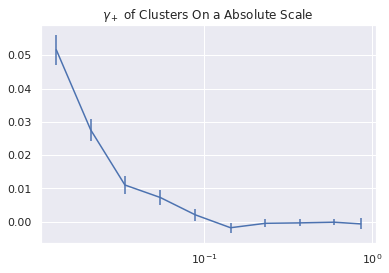

Aggregated xi:
[-32.3689 -38.1503 -24.2514 -27.4349 -12.8157  18.0355   6.9034   6.8667
   2.6743   5.6783]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -2712.8078  -5321.3965  -7432.1923 -10898.1879 -14765.2038 -19728.4192
 -22503.4796 -21346.9428 -12378.5248  -1397.5918]
------------------------------------------------------------------------------
Aggregated npairs:
[  627.  1380.  2195.  3756.  6098. 10180. 15421. 21631. 23920.  9090.]
------------------------------------------------------------------------------
Mean xi:
[-0.0516 -0.0276 -0.011  -0.0073 -0.0021  0.0018  0.0004  0.0003  0.0001
  0.0006]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.3266 -3.8561 -3.386  -2.9015 -2.4213 -1.938  -1.4593 -0.9869 -0.5175
 -0.1538]
------------------------------------------------------------------------------


In [25]:
plt_w_error(mean_abs[1],-mean_abs[0],sig_abs,r"$\gamma_+$ of Clusters On a Absolute Scale ")
print_data(sum_abs,mean_abs)

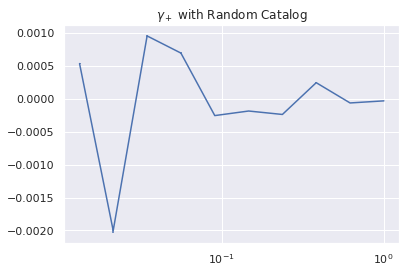

[ 5.3807e-04 -2.0032e-03  9.5860e-04  6.9755e-04 -2.5362e-04 -1.8407e-04
 -2.3639e-04  2.4706e-04 -6.1347e-05 -2.9438e-05]
[-8.3524e-06  3.1095e-05 -1.4880e-05 -1.0828e-05  3.9369e-06  2.8573e-06
  3.6694e-06 -3.8352e-06  9.5228e-07  4.5696e-07]


In [26]:
plt_w_error(r_meanlogr,-r_xi,r_sigma,r"$\gamma_+$ with Random Catalog")
print(-r_xi)
print(r_sigma)

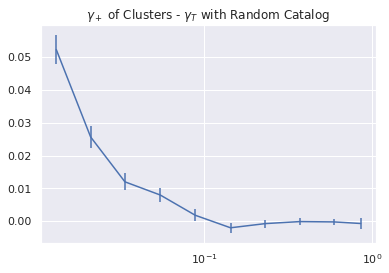

In [27]:
plt_w_error(mean_abs[1],-(mean_abs[0]+r_xi),np.hypot(r_sigma,sig_abs),r"$\gamma_+$ of Clusters - $\gamma_T$ with Random Catalog")

# Rel plots

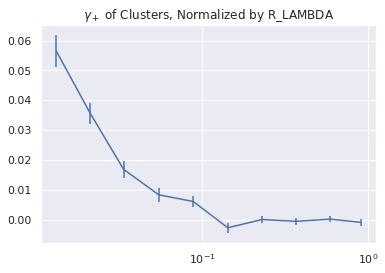

Aggregated xi:
[-22.9978 -38.2227 -31.4542 -25.6965 -30.6472  23.2648  -0.0622  11.8684
  -2.9927  16.9372]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -1761.246   -4132.5878  -6343.7114  -9022.9786 -12303.7435 -16310.3578
 -19352.7693 -19414.2655 -12810.189   -1939.4061]
------------------------------------------------------------------------------
Aggregated npairs:
[  407.  1071.  1869.  3104.  5064.  8369. 13112. 19358. 24078. 17959.]
------------------------------------------------------------------------------
Mean xi:
[-5.6506e-02 -3.5689e-02 -1.6829e-02 -8.2785e-03 -6.0520e-03  2.7799e-03
 -4.7429e-06  6.1310e-04 -1.2429e-04  9.4310e-04]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.3274 -3.8586 -3.3942 -2.9069 -2.4296 -1.9489 -1.476  -1.0029 -0.532
 -0.108 ]
------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [28]:
plt_w_error(mean_rel[1],-mean_rel[0],sig_rel,r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA")
print_data(sum_rel,mean_rel)